<h3><center>Introduction</center></h3>
<div style="font-family:verdana; word-spacing:1.7px;">
In this kernel we will be working with data from Google Cloud & NCAA® ML Competition 2019-Men's Challenge. We'll try to predict winners of NCAA based on previous tournaments! We have a lot of data, so let's start with EDA and then build a baseline model.

</div>

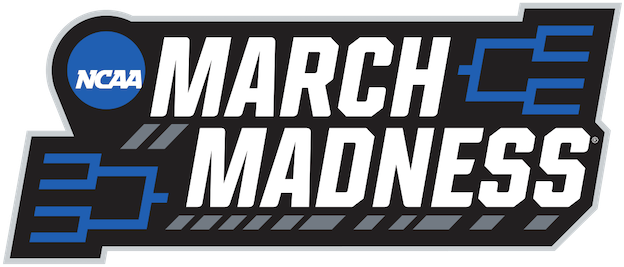

<h2><center>1. Importing Libraries</center></h2>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
from scipy import stats

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


import matplotlib.pylab as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal

import gc

import eli5

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, \
                                        RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

import lightgbm as lgb
import xgboost as xgb

In [ ]:
PATH_MEN = '/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/'

<h2><center>2. Exploring Data</center></h2>

<h3>2.1. Teams Data</h3>

<h3>Newbies</h3>

In [ ]:
MTeams = pd.read_csv(PATH_MEN + '/MDataFiles_Stage1/MTeams.csv')
MTeams.sort_values(by='FirstD1Season', ascending=False).head(10)

<h3>Oldies</h3>

In [ ]:
MTeams.sort_values(by='FirstD1Season').head(10)

<h3>2.2. Seasons Data</h3>

In [ ]:
MSeasons = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MSeasons.csv')

MSeasons.head()

<h3>2.3. Seed Data</h3>

In [ ]:
MNCAATourneySeeds = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
MNCAATourneySeeds.head()

<h3>2.4. Regular Season Results</h3>

In [ ]:
MRegularSeasonCompactResults = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
MRegularSeasonCompactResults.head()

<h3>Winning & losing Teams</h3>

In [ ]:
# Lets Add the winning and losing team names to the results
MRegularSeasonCompactResults = \
    MRegularSeasonCompactResults \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})

MRegularSeasonCompactResults.head()

In [ ]:
MRegularSeasonCompactResults['Score_Diff'] = MRegularSeasonCompactResults['WScore'] - MRegularSeasonCompactResults['LScore']

plt.style.use('fivethirtyeight')
MRegularSeasonCompactResults['Score_Diff'] \
    .plot(kind='hist',
          bins=90,
          figsize=(15, 5),
          label='Mens',
          alpha=0.5)
plt.title('Score Differential')
plt.xlim(0,60)
plt.legend()
plt.show()

In [ ]:
MRegularSeasonCompactResults

In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MRegularSeasonCompactResults['counter'] = 1
MRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values() \
    .tail(20) \
    .plot(kind='barh',
          title='⬆️ Most Regular Season Wins (Mens)',
          figsize=(15, 8),
          xlim=(600, 920),
          color=mypal[2],
         ax=axs[0])
MRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values(ascending=False) \
    .tail(20) \
    .plot(kind='barh',
          title='⬇️ Least Regular Season Wins (Mens)',
          figsize=(15, 8),
          xlim=(0, 150),
          color=mypal[3],
          ax=axs[1])
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

<h3>2.5. Event Data</h3>

Each event is assigned to either a team or a single one of the team's players. Thus if a basket is made by one player and an assist is credited to a second player, that would show up as two separate records. The players are listed by PlayerID within the xPlayers.csv file.

In [ ]:
mens_events = []
for year in [2015, 2016, 2017, 2018, 2019]:
    mens_events.append(pd.read_csv(f'{PATH_MEN}MEvents{year}.csv'))
MEvents = pd.concat(mens_events)
print(MEvents.shape)
MEvents.head()

In [ ]:
del mens_events
gc.collect()

In [ ]:
plt.style.use('fivethirtyeight')
MEvents['counter'] = 1
MEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='bar',
          figsize=(15, 5),
         color=mypal[2],
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()

<h3>Area Event</h3>

<div style="font-family:verdana; word-spacing:1.7px;">
We are told that the Area feature describes the 13 "areas" of the court, as follows: 1=under basket; 2=in the paint; 3=inside right wing; 4=inside right; 5=inside center; 6=inside left; 7=inside left wing; 8=outside right wing; 9=outside right; 10=outside center; 11=outside left; 12=outside left wing; 13=backcourt.
    </div>

In [ ]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

In [ ]:
MEvents.groupby('Area_Name')['counter'].sum() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 8),
          title='Frequency of Event Area')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, d in MEvents.loc[~MEvents['Area_Name'].isna()].groupby('Area_Name'):
    d.plot(x='X', y='Y', style='.', label=i, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

<h3>2.6. PlayerIDs</h3>

In [ ]:
MPlayers = pd.read_csv(PATH_MEN + 'MPlayers.csv', error_bad_lines=False)

MPlayers.head()

In [ ]:
del MEvents
del MNCAATourneySeeds
del MPlayers
del MRegularSeasonCompactResults
del MSeasons
del MTeams
gc.collect()

<h3><center>3. Preparing Training & Validation Data</center></h3>

In [ ]:
tourney_result = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_result = tourney_result[tourney_result['Season'] < 2015]

tourney_seed = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_seed = tourney_seed[tourney_seed['Season'] < 2015]

tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)

tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)

tourney_result = tourney_result.drop('TeamID', axis=1)


tourney_result['WSeed'] = tourney_result['WSeed'].apply(lambda x: int(x[1:3]))
tourney_result['LSeed'] = tourney_result['LSeed'].apply(lambda x: int(x[1:3]))

In [ ]:
season_result = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
season_result = season_result[season_result['Season'] < 2015]

season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]

season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)

season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)

season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()



tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)



tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)

tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']

In [ ]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

Training Data

In [ ]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
train_df = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
train_df.head()

In [ ]:
train_df['result'].value_counts()

In [ ]:
season_result.head()

In [ ]:
tourney_result.head()

Testing Data

In [ ]:
test_df = pd.read_csv(PATH_MEN+'MSampleSubmissionStage1_2020.csv')
sub = test_df.copy()

test_df.head()

In [ ]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))

In [ ]:
tourney_seed = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_seed = tourney_seed[tourney_seed['Season'] > 2014]

In [ ]:
season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
season_result = season_result[season_result['Season'] > 2014]
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()

In [ ]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)

In [ ]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: int(x[1:3]))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: int(x[1:3]))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df.head()

In [ ]:
X = train_df.drop('result', axis=1)
y = train_df.result

<h3><center>4. Model Test & Baseline result</center></h3>

In [ ]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

In [ ]:
model = DummyClassifier(strategy='uniform')

scores = evaluate_model(X, y, model)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

<h3><center>5. Evaluate Machine Learning Algorithms</center></h3>

In [ ]:
def get_models():
    models, names = list(), list()
    # LR 
    models.append(LogisticRegression(solver='lbfgs')) 
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis()) 
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

In [ ]:
models, names = get_models()

results = list()


for i in range(len(models)):
    
    pipeline = Pipeline(steps=[('scale',MinMaxScaler()),('m',models[i])])
    
    scores = evaluate_model(X, y, pipeline)
    
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores))) 

In [ ]:
plt.figure(figsize=(10,5))
_ = plt.boxplot(results, labels=names, showmeans=True) 
_ = plt.show()

In [ ]:
# LGB
lgb_num_leaves_max = 255
lgb_in_leaf = 50
lgb_lr = 0.0001
lgb_bagging = 7

# XGB
xgb_max_depth = 20
xgb_min_child_weight = 75
xgb_lr = 0.0005
xgb_num_boost_round_max = 4000
# without early_stopping_rounds

# Set weight of models
w_lgb = 0.6
w_xgb = 0.3
w_logreg = 1 - w_lgb - w_xgb

<h3>6. LGB</h3>

In [ ]:
params_lgb = {'num_leaves': lgb_num_leaves_max,
              'min_data_in_leaf': lgb_in_leaf,
              'objective': 'binary',
              'max_depth': -1,
              'learning_rate': lgb_lr,
              "boosting_type": "gbdt",
              "bagging_seed": lgb_bagging,
              "metric": 'logloss',
              "verbosity": -1,
              'random_state': 42,
             }

In [ ]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
#folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

columns = X.columns
splits = folds.split(X, y)
y_preds_lgb = np.zeros(test_df.shape[0])
y_train_lgb = np.zeros(X.shape[0])
y_oof = np.zeros(X.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    
    y_train_lgb += clf.predict(X) / NFOLDS
    y_preds_lgb += clf.predict(test_df) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(7,6)):
    y_pred = y_pred.round().astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
plot_cm(y, y_train_lgb, 'Confusion matrix for LGB model')

<h3>7. XGB</h3>

In [ ]:
params_xgb = {'max_depth': xgb_max_depth,
              'objective': 'binary:logistic',
              'min_child_weight': xgb_min_child_weight,
              'learning_rate': xgb_lr,
              'eta'      : 0.3,
              'subsample': 0.8,
              'lambda '  : 4,
              'eval_metric': 'logloss',
              'colsample_bytree ': 0.9,
              'colsample_bylevel': 1
              }

In [ ]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)

y_preds_xgb = np.zeros(test_df.shape[0])
y_train_xgb = np.zeros(X.shape[0])
y_oof_xgb = np.zeros(X.shape[0])

train_df_set = xgb.DMatrix(X)
test_set = xgb.DMatrix(test_df)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train, y_train)
    val_set = xgb.DMatrix(X_valid, y_valid)
    
    clf = xgb.train(params_xgb, train_set, num_boost_round=xgb_num_boost_round_max, evals=[(train_set, 'train'), (val_set, 'val')], verbose_eval=100)
    
    y_train_xgb += clf.predict(train_df_set) / NFOLDS
    y_preds_xgb += clf.predict(test_set) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

In [ ]:
plot_cm(y, y_train_xgb, 'Confusion matrix for XGB model')

<h3>8. Log Reg </h3>

In [ ]:
scale = MinMaxScaler()
X_scaled = scale.fit_transform(X)
X_test_scaled = scale.transform(test_df)

model = LogisticRegression(solver='liblinear')

model.fit(X_scaled, y)

y_logreg_train = model.predict(X_scaled)
y_logreg_pred = model.predict(X_test_scaled)

In [ ]:
plot_cm(y, y_logreg_train, 'Confusion matrix for LogReg model')

<h3><center>9. Merging Solutions</center></h3>

In [ ]:
y_train_preds = 0.8*y_train_lgb + 0.1*y_train_xgb + 0.1*y_logreg_train

plot_cm(y, y_train_preds, 'Confusion matrix for Merging solution')
